In [1]:
import pandas as pd
import networkx as nx
import json

In [3]:
df=pd.read_csv('data_scopus.csv')

In [5]:
nodes=df['EID'].values
df=df.fillna(0)

In [6]:
G=nx.Graph()

In [7]:
nodes=[]
for row in df.iterrows():
    nodes.append((row[1]['EID'],{
                 "Title": row[1]['Title'],
                 "Year" : row[1]['Year'],
                 "Citation" : row[1]['Cited by'],
                 "Publisher": row[1]['Publisher'],
                 }))

In [8]:
nodes

[('2-s2.0-85086464158',
  {'Title': 'Virtual reality applications for the built environment: Research trends and opportunities',
   'Year': 2020,
   'Citation': 0.0,
   'Publisher': 'Elsevier B.V.'}),
 ('2-s2.0-85082875828',
  {'Title': 'Self-tracking while doing sport: Comfort, motivation, attention and lifestyle of athletes using personal informatics tools',
   'Year': 2020,
   'Citation': 0.0,
   'Publisher': 'Academic Press'}),
 ('2-s2.0-85078194587',
  {'Title': 'Bridge damage: Detection, IFC-based semantic enrichment and visualization',
   'Year': 2020,
   'Citation': 0.0,
   'Publisher': 'Elsevier B.V.'}),
 ('2-s2.0-85075706132',
  {'Title': 'VR system for spatio-temporal visualization of tweet data and support of map exploration',
   'Year': 2019,
   'Citation': 0.0,
   'Publisher': 'Springer'}),
 ('2-s2.0-85074886243',
  {'Title': 'DiseaSE: A biomedical text analytics system for disease symptom extraction and characterization',
   'Year': 2019,
   'Citation': 0.0,
   'Publishe

In [9]:
G.add_nodes_from(nodes)

In [12]:
edges = []
for row in df.iterrows():
  current_paper = row[1]['EID']
  if";" in row[1]['Author(s) ID']:
    authors = row[1]['Author(s) ID'][:-1].split(';')
    for author in authors:
      papers = df[df['Author(s) ID'].str.contains(author)]['EID'].values
      for paper in papers:
        if paper != current_paper:
          edge.append((current_paper,paper))
  else:
    continue

In [13]:
G.add_edges_from(edges)

In [14]:
pos = nx.drawing.circular_layout(G)


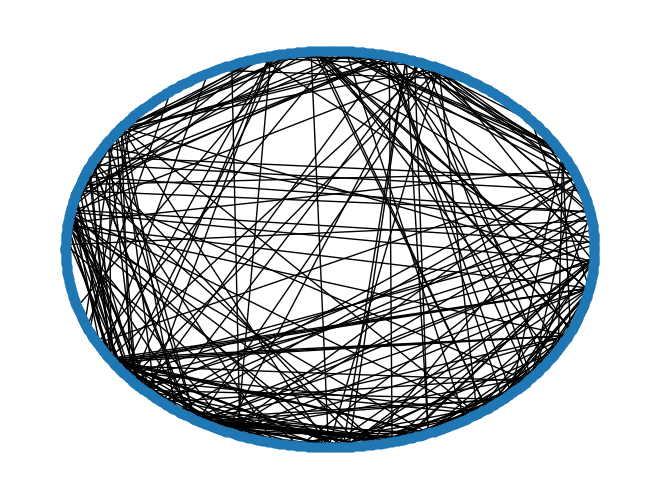

In [15]:
nx.draw(G, pos=pos, node_size=40)

In [16]:
from networkx.readwrite import json_graph

In [17]:
with open("publication_network.json", "w") as f:
    json.dump(json_graph.node_link_data(G), f)

/usr/local/lib/python3.10/dist-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(
